In [83]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Database connection
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

# Set plotting style and configuration
sns.set_theme()  # Use seaborn's default theme
plt.style.use('default')  # Use matplotlib's default style
%matplotlib inline

# Load environment variables
load_dotenv()

True

In [84]:
# Create database connection
db_user = os.getenv('DB_USER', 'lmia_user')
db_password = os.getenv('DB_PASSWORD', 'lmia_password')
db_host = os.getenv('DB_HOST', 'localhost')
db_name = os.getenv('DB_NAME', 'lmia_stats')

# Create SQLAlchemy engine
engine = create_engine(f'mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_name}')

In [85]:
# SQL query to fetch software engineering related LMIAs
query = """
SELECT DISTINCT e.occupation
FROM employers e
WHERE e.occupation LIKE '%%oftware%%'
   OR e.occupation LIKE '%%eveloper%%'
   OR e.occupation LIKE '%%rogrammer%%'
   OR e.occupation LIKE '%%atabase%%'
   OR e.occupation LIKE '%%Data Scien%%'
ORDER BY e.occupation
"""

# Load data into pandas DataFrame
df = pd.read_sql(query, engine)
occupations = df["occupation"]
print(df)

                                           occupation
0                               21211-Data scientists
1     21223-Database analysts and data administrators
2   21230-Computer systems developers and programmers
3              21231-Software engineers and designers
4           21232-Software developers and programmers
5                21234-Web developers and programmers
6   21311-Computer engineers (except software engi...
7   2147-Computer engineers (except software engin...
8      2172-Database analysts and data administrators
9               2173-Software engineers and designers
10  2174-Computer programmers and interactive medi...
11                  2175-Web designers and developers


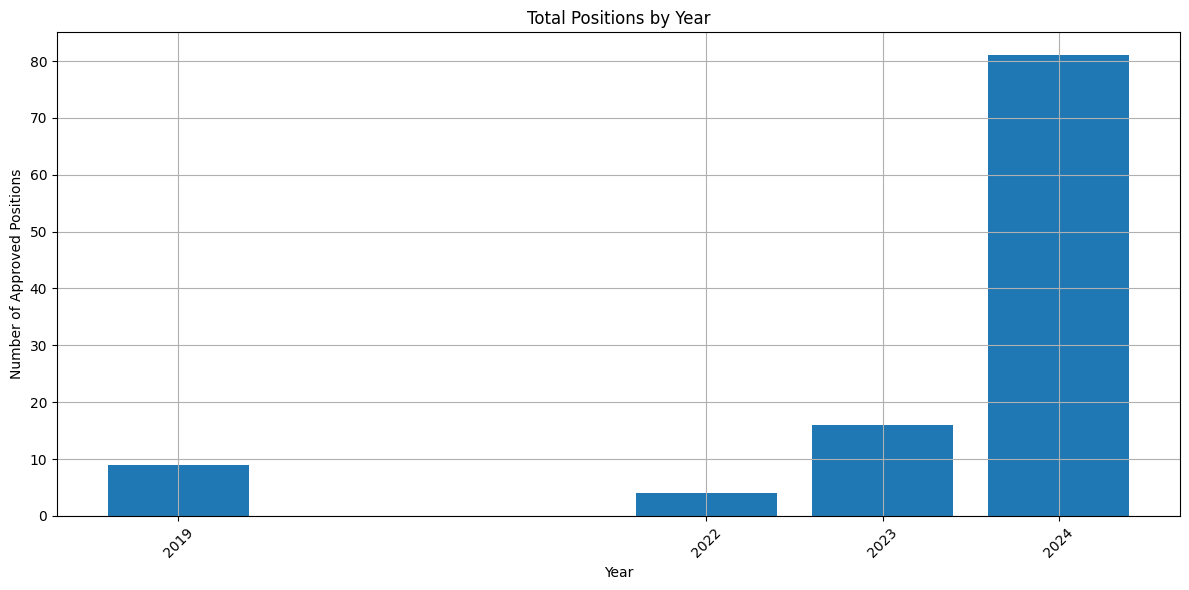

In [86]:
occupation_list = occupations.tolist()
occupations_str = ", ".join(f"'{occ}'" for occ in occupation_list)

query = f"""
SELECT 
    year,
    SUM(approved_positions) AS approved_positions
FROM employers e
WHERE occupation IN ({occupations_str}) AND e.employer LIKE '%%Autodesk%%'
GROUP BY year
ORDER BY year;
"""

# Load data into a DataFrame
yearly_stats = pd.read_sql(query, engine).round(2)
yearly_stats['year'] = yearly_stats['year'].astype(int)
plt.figure(figsize=(12, 6))
plt.bar(yearly_stats['year'], yearly_stats['approved_positions'])

plt.title('Total Positions by Year')
plt.xlabel('Year')
plt.ylabel('Number of Approved Positions')
plt.xticks(yearly_stats['year'], rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()
